<a href="https://colab.research.google.com/github/allicodi/bsta001_final/blob/main/BSTA_001_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [203]:
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import datetime
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [204]:
caseData = pd.read_csv('https://covidtracking.com/data/download/all-states-history.csv')

In [205]:
policyData_raw = pd.read_csv('/content/drive/My Drive/COVID-19_policy.csv') #change per person
# /content/drive/My Drive/BSTA001/covid_policy_data_11_3_2020.csv #for alli
# /content/drive/My Drive/COVID-19_policy.csv # for nora
policyData = policyData_raw[4:55] #the postcodes (state Abbrev) are not alphabetical

In [206]:
policyData.head()

,STATE,POSTCODE,FIPS,STEMERG,CLSCHOOL,CLDAYCR,OPNCLDCR,CLNURSHM,STAYHOME,STAYHOMENOGP,END_STHM,CLBSNS,END_BSNS,RELIGEX,FM_ALL,FMFINE,FMCITE,FMNOENF,FM_EMP,FM_END,FM_STP,ALCOPEN,ALCREST,ALCDELIV,GUNOPEN,CLREST,ENDREST,RSTOUTDR,CLGYM,ENDGYM,CLMOVIE,END_MOV,CLOSEBAR,END_BRS,END_HAIR,END_RELG,ENDRETL,BCLBAR2,CLBAR2,CLMV2,...,UICLDCR,UIEXTND,UIMAXAMT,UIMAXEXT,UIMAXDUR,UIMAXCAR,UIMINBP,UIQTRNEED,UIOUTHQBP,UIREQBPL2Q,UIBPEARN300,UITAXWA,UIMINTAXR,UIMAXTAXR,UIAVGBFTAUG,LMABRN,TLHlBUPR,EXTOPFL,HMDLVOP,TLHLCL24,EXCEMORP,WVDEAREQ,PDSKLV,MEDEXP,POPDEN18,POP18,SQML,HMLS19,UNEMP18,POV18,RISKCOV,DEATH18,MH19,VBMEXC,VBMSIG,VBMPERM,VBMAUTOBAL,VBMAUTOAP,VBMGENELEC,Unnamed: 162
4,Alabama,AL,1,3/13/20,3/20/20,3/20/20,5/23/20,3/19/20,4/4/20,0,4/30/20,3/28/20,4/30/20,0,7/16/20,0,0,1,5/11/20,0,0,1,3/24/20,3/24/20,1,3/19/20,5/11/20,0,3/28/20,5/11/20,3/28/20,5/22/20,3/19/20,5/11/20,5/11/20,5/11/20,4/30/20,0,0,0,...,0,0,275,875,20,39,2340,2,780,0,Max Benefit < $300,8000,0.65,6.8,$250.77,1,0,0,0,3/20/20,0,0,0,0,93.24,4887871,52420,"3,261",5.6,16.8,43.1,"54,352",100.7,0,1,0,0,0,10/29/20,NaN
5,Alaska,AK,2,3/11/20,3/16/20,0,0,0,3/28/20,0,4/24/20,3/24/20,4/24/20,0,4/24/20,1,1,0,4/24/20,5/22/20,0,1,3/17/20,3/17/20,1,3/18/20,4/24/20,0,3/18/20,5/8/20,3/18/20,5/8/20,3/18/20,5/8/20,4/24/20,5/8/20,4/24/20,0,0,0,...,1,0,370,970,26,39,2500,2,250,0,13636.36,41500,1,5.4,$443.23,1,0,0,0,0,0,0,0,1,1.11,737438,665384,"1,907",6.8,10.9,32.8,"4,453",429.9,0,1,0,0,2,10/24/20,NaN
6,Arizona,AZ,4,3/11/20,3/16/20,0,0,0,3/31/20,0,5/16/20,3/31/20,5/8/20,1,0,0,0,0,5/8/20,0,3/30/20,1,3/19/20,3/19/20,1,3/21/20,5/11/20,0,3/21/20,5/13/20,3/21/20,5/16/20,3/21/20,5/16/20,5/8/20,0,5/8/20,6/29/20,6/29/20,6/29/20,...,1,0,240,840,26,39,7020,2,2340,0,Max Benefit < $300,7000,0.05,12.85,$237.99,0,0,0,0,0,3/11/20,0,1,1,62.91,7171646,113990,"10,007",5.4,14,39.1,"59,282",132.9,0,0,0,0,0,10/23/20,NaN
7,Arkansas,AR,5,3/11/20,3/17/20,0,0,3/13/20,0,0,0,4/6/20,5/4/20,0,7/20/20,1,1,0,5/11/20,0,0,1,3/19/20,3/19/20,1,3/20/20,5/11/20,0,3/20/20,5/4/20,3/20/20,5/18/20,3/20/20,5/19/20,5/6/20,0,5/18/20,0,0,0,...,0,0,451,1051,16,33,2835,2,1,0,31200,7000,0.1,6,$223.84,1,0,0,0,0,0,0,0,1,56.67,3013825,53179,"2,717",4.5,17.2,43.5,"32,336",231.6,0,0,0,0,0,10/27/20,NaN
8,California,CA,6,3/4/20,3/23/20,0,0,0,3/19/20,0,0,3/19/20,5/8/20,0,6/18/20,0,0,1,5/5/20,0,0,1,3/19/20,3/19/20,0,3/16/20,5/18/20,0,3/19/20,0,3/19/20,0,3/16/20,0,8/28/20,5/25/20,5/8/20,0,0,7/13/20,...,0,0,450,1050,26,39,1125,2,225,0,6900,7000,1.5,6.2,$282.35,0,0,0,0,0,0,0,1,1,241.65,39557045,163695,"151,278",5.5,12.8,33.3,"268,818",356.2,0,0,0,1,0,0,NaN


In [207]:
#for cols in policyData.columns: #checking column titles
 # print(cols)

In [208]:
caseData.head()

,date,state,dataQualityGrade,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,inIcuCumulative,inIcuCurrently,negative,negativeIncrease,negativeTestsAntibody,negativeTestsPeopleAntibody,negativeTestsViral,onVentilatorCumulative,onVentilatorCurrently,positive,positiveCasesViral,positiveIncrease,positiveScore,positiveTestsAntibody,positiveTestsAntigen,positiveTestsPeopleAntibody,positiveTestsPeopleAntigen,positiveTestsViral,recovered,totalTestEncountersViral,totalTestEncountersViralIncrease,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease
0,2020-12-07,AK,A,146.0,146.0,3,NaN,805.0,805.0,166.0,6,NaN,NaN,1045944.0,3888,NaN,NaN,1037022.0,NaN,24.0,36196.0,NaN,476,0,NaN,NaN,NaN,NaN,43903.0,7165.0,NaN,0,1082140.0,4364,NaN,NaN,NaN,NaN,NaN,0,1082140.0,4364
1,2020-12-07,AL,A,3892.0,3465.0,3,427.0,27044.0,27044.0,2079.0,713,2290.0,NaN,1425784.0,4658,NaN,NaN,NaN,1317.0,NaN,272229.0,225789.0,2352,0,NaN,NaN,NaN,NaN,NaN,168387.0,NaN,0,1651573.0,6532,NaN,NaN,74956.0,NaN,1651573.0,6532,NaN,0
2,2020-12-07,AR,A+,2713.0,2485.0,53,228.0,9445.0,9445.0,1053.0,44,NaN,382.0,1623898.0,8919,NaN,NaN,1623898.0,1044.0,182.0,172042.0,149175.0,1118,0,NaN,3300.0,NaN,27881.0,NaN,151248.0,NaN,0,1773073.0,9923,NaN,21856.0,NaN,156801.0,NaN,0,1773073.0,9923
3,2020-12-07,AS,D,0.0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,2140.0,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2140.0,0,NaN,NaN,NaN,NaN,NaN,0,2140.0,0
4,2020-12-07,AZ,A+,6950.0,6431.0,0,519.0,28273.0,28273.0,3059.0,25,NaN,736.0,2035704.0,16891,NaN,NaN,NaN,NaN,459.0,365843.0,353135.0,1567,0,NaN,NaN,NaN,NaN,NaN,57040.0,NaN,0,2388839.0,18340,371261.0,NaN,NaN,NaN,2388839.0,18340,NaN,0


In [209]:
caseData['date'] = caseData['date'].astype('datetime64[ns]') #converts date attribute from string type to datetime type to be used for calculations

#gather dates of face mask mandates and their respective states
dateOfFM = policyData.FM_ALL 
stateOfFM = policyData.POSTCODE 
citeYN = policyData.FMCITE
fineYN = policyData.FMFINE

dateOfFM = pd.to_datetime(dateOfFM, errors = 'coerce') #converts date face mask mandate implemented from string type to datetime type to be used for calculations

In [210]:
caseData.info() #look at types and verify datetime conversion worked

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15689 entries, 0 to 15688
Data columns (total 42 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              15689 non-null  datetime64[ns]
 1   state                             15689 non-null  object        
 2   dataQualityGrade                  14428 non-null  object        
 3   death                             14863 non-null  float64       
 4   deathConfirmed                    6883 non-null   float64       
 5   deathIncrease                     15689 non-null  int64         
 6   deathProbable                     5131 non-null   float64       
 7   hospitalized                      9472 non-null   float64       
 8   hospitalizedCumulative            9472 non-null   float64       
 9   hospitalizedCurrently             12569 non-null  float64       
 10  hospitalizedIncrease              15689 non-nu

In [211]:
#keeping only necessary columns

dataUnclean = caseData[['date', 'state', 'positiveIncrease']]
#dataFinal = caseData.drop(['dataQualityGrade' , 'death' ,	'deathConfirmed', 	'deathIncrease' ,	'deathProbable' ,	'hospitalized'	,'hospitalizedCumulative'	,'hospitalizedCurrently'	,'hospitalizedIncrease'	,'inIcuCumulative'	,'inIcuCurrently'	,'negative'	,'negativeIncrease'	,'negativeTestsAntibody'	,'negativeTestsPeopleAntibody',	'negativeTestsViral',	'onVentilatorCumulative'	,'onVentilatorCurrently'	,'positive'	,'positiveCasesViral', 'positiveScore'	,'positiveTestsAntibody'	,'positiveTestsAntigen'	,'positiveTestsPeopleAntibody'	,'positiveTestsPeopleAntigen'	,'positiveTestsViral'	,'recovered'	,'totalTestEncountersViral'	,'totalTestEncountersViralIncrease'	,'totalTestResults'	,'totalTestResultsIncrease'	,'totalTestsAntibody'	,'totalTestsAntigen'	,'totalTestsPeopleAntibody',	'totalTestsPeopleAntigen'	,'totalTestsPeopleViral'	,'totalTestsPeopleViralIncrease'	,'totalTestsViral'	,'totalTestsViralIncrease'], axis = 1)
dataUnclean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15689 entries, 0 to 15688
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              15689 non-null  datetime64[ns]
 1   state             15689 non-null  object        
 2   positiveIncrease  15689 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 367.8+ KB


In [212]:
dataFinal = dataUnclean[~(dataUnclean['positiveIncrease'] <= 0)]  #remove all positive increase data less than 0

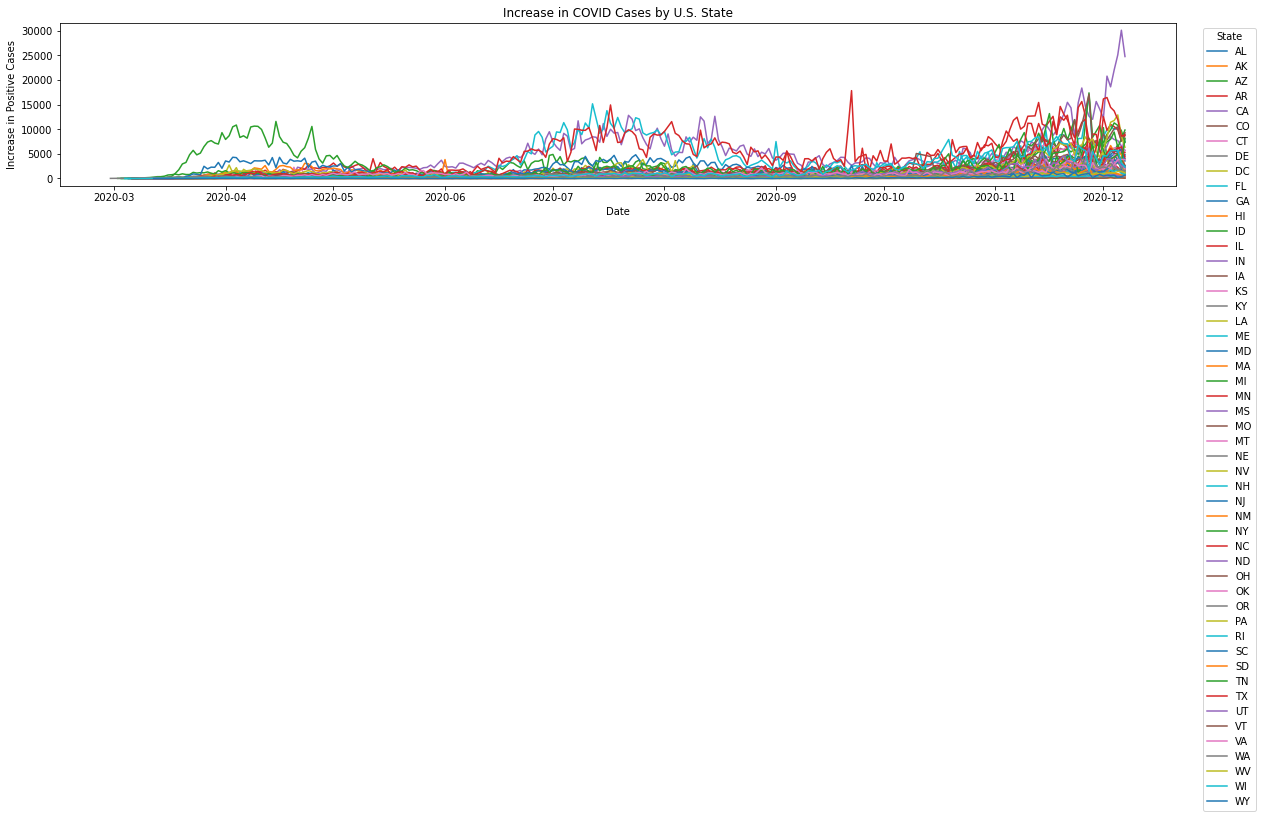

In [213]:
#question for prof m - how to change legend so no color repeats (use dashed lines, etc.)

fig, ax = plt.subplots(figsize=(20,3))

casesByState = []

stateAbbrev = policyData.POSTCODE

for state in stateAbbrev: # for loop for separating case data by state
  stateCases = dataFinal.loc[dataFinal['state'] == state] 
  casesByState.append(stateCases)
  #graph of state case increases over time
  x = stateCases.date
  y = stateCases.positiveIncrease
  ax.plot(x, y, label=state)
  
ax.set_title('Increase in COVID Cases by U.S. State')
ax.set_xlabel('Date')
ax.set_ylabel('Increase in Positive Cases')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), title='State')
plt.show()

In [214]:
#data needs cleaning, one state has greater than -5000 pos. inc, pretty sure it's NM

In [215]:
FMdf = pd.DataFrame({'FM_ALL':dateOfFM, 'State':stateOfFM}) #making data frame of face mask mandates

for col in FMdf.columns: #checking column titles
  print(col)

FMdf = FMdf.dropna(axis=0) #remove all states with FM_ALL = NaT

print(FMdf)

FM_ALL
State
       FM_ALL State
4  2020-07-16    AL
5  2020-04-24    AK
7  2020-07-20    AR
8  2020-06-18    CA
9  2020-07-16    CO
10 2020-04-20    CT
11 2020-04-28    DE
12 2020-04-17    DC
15 2020-04-16    HI
17 2020-05-01    IL
18 2020-07-27    IN
20 2020-07-03    KS
21 2020-05-11    KY
23 2020-05-01    ME
24 2020-04-18    MD
25 2020-05-06    MA
26 2020-04-27    MI
27 2020-07-24    MN
28 2020-08-05    MS
32 2020-06-26    NV
34 2020-04-08    NJ
35 2020-05-15    NM
36 2020-04-17    NY
37 2020-06-26    NC
39 2020-07-23    OH
41 2020-07-01    OR
42 2020-07-01    PA
43 2020-04-18    RI
47 2020-07-03    TX
48 2020-04-10    UT
49 2020-08-01    VT
50 2020-05-29    VA
51 2020-06-26    WA
52 2020-07-07    WV
53 2020-08-01    WI


In [216]:
beforeDate = []
afterDateBegin = []
afterDateEnd = []

for date in FMdf.FM_ALL:  #calculate two week periods before and after mandate implementation
  beforeDate.append(date - datetime.timedelta(days=14))
  afterDateBegin.append(date + datetime.timedelta(days=14))
  afterDateEnd.append(date + datetime.timedelta(days=28))

  
FMdf['TwoWksBefore'] = beforeDate
FMdf['TwoWksAfter'] = afterDateBegin
FMdf['FourWksAfter'] = afterDateEnd

FMdf.head()  

,FM_ALL,State,TwoWksBefore,TwoWksAfter,FourWksAfter
4,2020-07-16,AL,2020-07-02,2020-07-30,2020-08-13
5,2020-04-24,AK,2020-04-10,2020-05-08,2020-05-22
7,2020-07-20,AR,2020-07-06,2020-08-03,2020-08-17
8,2020-06-18,CA,2020-06-04,2020-07-02,2020-07-16
9,2020-07-16,CO,2020-07-02,2020-07-30,2020-08-13


In [217]:
avgCasesBefore = []
avgCasesAfter = []

for i in FMdf.index: #cycle through all states and calculate avg increase over time frame
  positiveIncrease = []
  state = FMdf['State'][i] # get state at index
  data = dataFinal.loc[dataFinal['state'] == state] #get policy data associated with state
  
  before = data.loc[(data.date>=FMdf['TwoWksBefore'][i]) & (data.date<=FMdf['FM_ALL'][i]),:].positiveIncrease #data from two week period before policy implemented
  after = data.loc[(data.date >= FMdf['TwoWksAfter'][i]) & (data.date<=FMdf['FourWksAfter'][i]),:].positiveIncrease #data from two week period after policy implemented
  
  avgCasesBefore.append(np.mean(before)) #calc averages
  avgCasesAfter.append(np.mean(after))

FMdf['avgCasesBefore'] = avgCasesBefore #add list of averages to the dataframe
FMdf['avgCasesAfter'] = avgCasesAfter

In [218]:
FMdf.head()

,FM_ALL,State,TwoWksBefore,TwoWksAfter,FourWksAfter,avgCasesBefore,avgCasesAfter
4,2020-07-16,AL,2020-07-02,2020-07-30,2020-08-13,1475.066667,1451.666667
5,2020-04-24,AK,2020-04-10,2020-05-08,2020-05-22,6.933333,2.461538
7,2020-07-20,AR,2020-07-06,2020-08-03,2020-08-17,893.166667,792.615385
8,2020-06-18,CA,2020-06-04,2020-07-02,2020-07-16,2894.133333,8002.600000
9,2020-07-16,CO,2020-07-02,2020-07-30,2020-08-13,379.800000,428.200000


In [219]:
statesWithPolicies = [FMdf['State'][i] for i in FMdf.index if str(FMdf['FM_ALL'][i]) != 'NaT'] #might use this to eliminate states w/o policy from graph below, still have to implement
print(statesWithPolicies)
len(statesWithPolicies)

['AL', 'AK', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'HI', 'IL', 'IN', 'KS', 'KY', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'NV', 'NJ', 'NM', 'NY', 'NC', 'OH', 'OR', 'PA', 'RI', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI']


35

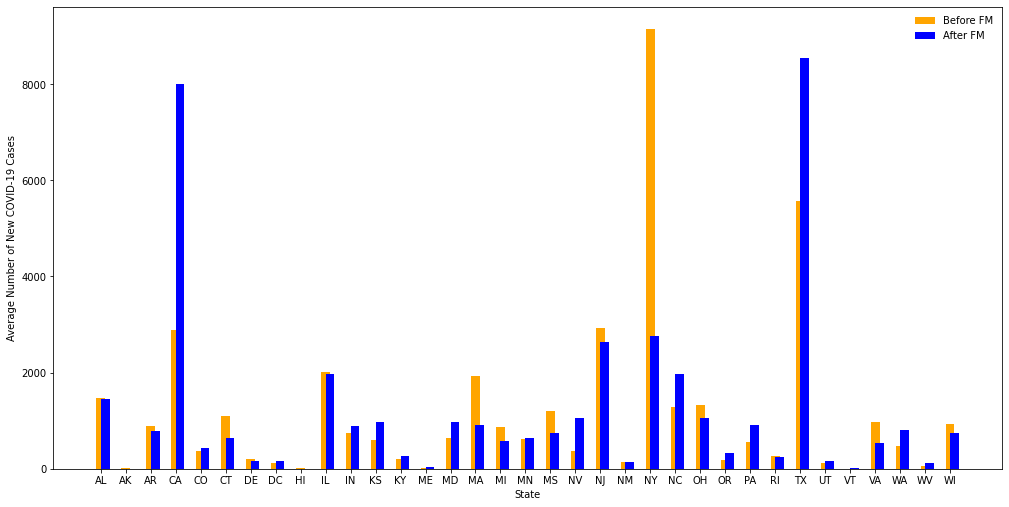

In [220]:
#plot data
from matplotlib.pyplot import figure

width = 0.35  #width of bars

fig, ax = plt.subplots()
rects1 = ax.bar(FMdf.State, FMdf.avgCasesBefore, width, align= 'center', color='orange', label='Before FM')
rects2 = ax.bar(FMdf.State, FMdf.avgCasesAfter, width, align= 'edge', color='blue', label='After FM')
ax.set_ylabel('Average Number of New COVID-19 Cases')
ax.set_xlabel('State')
ax.set_xticklabels(FMdf.State)
ax.legend(frameon=False)
fig.set_size_inches(17, 8.5, forward=True)

**Things to do:**


*   Pick/use statistical test(s)



1.   Hypothesis test for two week period around face mask policy implementation - Paired T-Test

  *   H0 : policy does not impact average increase in cases(after - before = 0 )
  *   H1 : policy decreases average increase in cases (after - before <= 0)

2.    Chi-Squared Test/2x2 Table - states with fines x states with criminal charges (FMFINE vs FMCITE) 
  *   Shows differences in behavior enforcement - is some policy more effective than others?
  *   Treat increase or decrease as 0/1
  *   Fines vs Not fines - states increase vs decrease
  *   Fines vs Citations - states increase vs decrease

3.    Linear regression for behavior vs avg increase in number of cases
  *   X = 0 for citation, X = 1 for fines
  *   Y = average two weeks after

**Future Directions:**
*   Look at other variables w/ dates
    * Bar shutdown, school shutdown, restaurant reopen, religious gatherings limited
    * Bar reopen, school reopen, restaurant reopen, religious gatherings reopen
*   Look at FM related variables
    * FM mandate enforced by fines, FM mandate enforced by criminal charge
    *   List of Face Mask Related Attributes
    * Mandate face mask use by all individuals in public spaces	(date)
    * Face mask mandate enforced by fines	(binary)
    * Face mask mandate enforced by criminal charge/citation	(binary)
    * No legal enforcement of face mask mandate	Mandate face mask use by employees in public-facing businesses	(date)
    * State ended statewide mask use by individuals in public spaces (date)	
    * Attempt by state government to prevent local governments from implementing face mask orders (date)




In [221]:
print(FMdf)

       FM_ALL State TwoWksBefore  ... FourWksAfter avgCasesBefore  avgCasesAfter
4  2020-07-16    AL   2020-07-02  ...   2020-08-13    1475.066667    1451.666667
5  2020-04-24    AK   2020-04-10  ...   2020-05-22       6.933333       2.461538
7  2020-07-20    AR   2020-07-06  ...   2020-08-17     893.166667     792.615385
8  2020-06-18    CA   2020-06-04  ...   2020-07-16    2894.133333    8002.600000
9  2020-07-16    CO   2020-07-02  ...   2020-08-13     379.800000     428.200000
10 2020-04-20    CT   2020-04-06  ...   2020-05-18    1087.692308     630.642857
11 2020-04-28    DE   2020-04-14  ...   2020-05-26     210.714286     166.733333
12 2020-04-17    DC   2020-04-03  ...   2020-05-15     121.533333     169.866667
15 2020-04-16    HI   2020-04-02  ...   2020-05-14      21.466667       2.230769
17 2020-05-01    IL   2020-04-17  ...   2020-05-29    2021.466667    1967.866667
18 2020-07-27    IN   2020-07-13  ...   2020-08-24     753.000000     884.266667
20 2020-07-03    KS   2020-0

In [222]:
#Chi Square tests

In [223]:
#prepare dataframes for rate and citation (0/1) and rate and fine(0/1)
rateDifference = []
print(FMdf.index)

#organize decreases and increases in avg case incidence before and after FM mandate
for i in FMdf.index: 
  before = FMdf['avgCasesBefore'][i] 
  after = FMdf['avgCasesAfter'][i]
  diff = after - before
  if diff < 0:
    rateDifference.append(1) #mask mandate worked
  else:
    rateDifference.append(0) #mandate didnt work
#print(len(rateDifference))
#print(rateDifference)

Int64Index([ 4,  5,  7,  8,  9, 10, 11, 12, 15, 17, 18, 20, 21, 23, 24, 25, 26,
            27, 28, 32, 34, 35, 36, 37, 39, 41, 42, 43, 47, 48, 49, 50, 51, 52,
            53],
           dtype='int64')


In [224]:
policyDataClean = pd.DataFrame({'FM_ALL':dateOfFM, 'State':stateOfFM, 'FMFINE':fineYN, 'FMCITE':citeYN}) #making data frame for easy cleaning of NaT
policyDataClean = policyDataClean.dropna(axis=0) #remove all states w/ FM_ALL = NaT for matching equal column lengths
#print(len(policyDataClean))

fine = policyDataClean.FMFINE
cite = policyDataClean.FMCITE

#print(len(fine))
#print(len(cite))
ratesAndFine= pd.DataFrame({'rate diff':rateDifference, 'fine':fine})
ratesAndCite = pd.DataFrame({'rate diff':rateDifference, 'cite':cite})

In [225]:
# manual 2x2 chi square test for rate vs fine, note: matches function in next cell

#define variables
DecRYFine = 0 #decrease rate, yes fine
IncRYFine = 0 #increase rate, yes fine
DecRNFine = 0 #decrease rate, no fine
IncRNFine = 0 #increase rate, no fine

#count number observations in each 2x2 variable
for i in ratesAndFine.index:

  R = ratesAndFine['rate diff'][i] 
  F = ratesAndFine['fine'][i] 

  if R == 1 and F == "1":
    DecRYFine += 1
  if R == 0 and F == "1":
    IncRYFine += 1
  if R == 1 and F == "0":
    DecRNFine += 1
  if R == 0 and F == "0":
    IncRNFine += 1

#print(DecRYFine)
#print(IncRYFine)
#print(DecRNFine)
#print(IncRNFine)

#sum of var
allI = IncRYFine + IncRNFine #all observed increases in rate
allD = DecRYFine + DecRNFine #all observed decreases in rate
allY = DecRYFine + IncRYFine #all observed yes fines
allN = DecRNFine + IncRNFine #all observed no fines
all = len(ratesAndFine) #all observed
#print(all)

#probs
probI = allI / all
probD = allD / all
probY = allY / all
probN = allN / all

#expected values
ExDecRYFine = probD * probY *all
ExIncRYFine = probI * probY *all
ExDecRNFine = probD * probN *all
ExIncRNFine = probI * probN *all

print(DecRYFine)
print(ExDecRYFine)

#Goodness of fit
gFitDecRYFine = (DecRYFine - ExDecRYFine)**2 / ExDecRYFine
gFitIncRYFine = (IncRYFine - ExIncRYFine)**2 / ExIncRYFine
gFitDecRNFine = (DecRNFine - ExDecRNFine)**2 / ExDecRNFine
gFitIncRNFine = (IncRNFine - ExIncRNFine)**2 / ExIncRNFine

#calc chi square test stat
chiTestStat = gFitDecRYFine + gFitIncRYFine + gFitDecRNFine + gFitIncRNFine
print(chiTestStat)

9
7.285714285714286
1.372549019607843


In [226]:
# Crosstab function for chi square 2x2 rate vs fine

O1 = pd.crosstab(index=ratesAndFine["rate diff"]       # the rows (index)
                ,columns=ratesAndFine["fine"]) # the columns (columns) #build 2x2 table for rate increase(0)/decrease(1) and fine (0/1)
print(O1)

from scipy.stats import chi2_contingency
testStat, pvalue,df,E = scipy.stats.chi2_contingency(O1)
print("Chisqares test statistic (w/ Yates' correction)= {:.2f}".format(testStat)) #print chi square test stat w/ Yates' correction
print("Pvalue = {:.3f}".format(pvalue)) #print correspond p value

fine        0  1
rate diff       
0          12  6
1           8  9
Chisqares test statistic (w/ Yates' correction)= 0.69
Pvalue = 0.407


Pvalue > .05, therefore, no significant difference

In [227]:
# manual 2x2 chi square test for rate vs citation, note: matches function in next cell

#define variables
DecRYCite = 0 #decrease rate, yes cite
IncRYCite = 0 #increase rate, yes cite
DecRNCite = 0 #decrease rate, no cite
IncRNCite = 0 #increase rate, no cite

#count number observations in each 2x2 variable
for i in ratesAndCite.index:

  R = ratesAndCite['rate diff'][i] 
  C = ratesAndCite['cite'][i] 

  if R == 1 and C == "1":
    DecRYCite += 1
  if R == 0 and C == "1":
    IncRYCite += 1
  if R == 1 and C == "0":
    DecRNCite += 1
  if R == 0 and C == "0":
    IncRNCite += 1

#sum of var 
allI2 = IncRYCite + IncRNCite
allD2 = DecRYCite + DecRNCite
allC = DecRYCite + IncRYCite
allN2 = DecRNCite + IncRNCite
all2 = len(ratesAndCite)

#probabilities
probI2 = allI2 / all2
probD2 = allD2 / all2
probC = allC / all2
probN2 = allN2 / all2

#expected values
ExDecRYCite = probD2 * probC *all2
ExIncRYCite = probI2 * probC *all2
ExDecRNCite = probD2 * probN2 *all2
ExIncRNCite = probI2 * probN2 *all2

#Goodness of fit
gFitDecRYCite = (DecRYCite - ExDecRYCite)**2 / ExDecRYCite
gFitIncRYCite = (IncRYCite - ExIncRYCite)**2 / ExIncRYCite
gFitDecRNCite = (DecRNCite - ExDecRNCite)**2 / ExDecRNCite
gFitIncRNCite = (IncRNCite - ExIncRNCite)**2 / ExIncRNCite

#calc chi square test stat
chiTestStat2 = gFitDecRYCite + gFitIncRYCite + gFitDecRNCite + gFitIncRNCite
print(chiTestStat2)

1.4574668251138836


In [228]:
# Crosstab function for chi square 2x2 rate vs citation

O2 = pd.crosstab(index=ratesAndCite["rate diff"]  
                ,columns=ratesAndCite["cite"]) #build 2x2 table for rate increase(0)/decrease(1) and citation (0/1)
print(O2) 

testStat, pvalue,df,E = scipy.stats.chi2_contingency(O2)
print("Chisqares test statistic (w/ Yates' correction)= {:.2f}".format(testStat)) #print chi square test stat w/ Yates' correction
print("Pvalue = {:.3f}".format(pvalue)) #print correspond p value

cite        0  1
rate diff       
0          14  4
1          10  7
Chisqares test statistic (w/ Yates' correction)= 0.71
Pvalue = 0.399


Pvalue > .05, therefore, no significant difference

Pvalue,citation > Pvalue,fine, therefore, there is a more significant relationship between the presence of a citation and case incidence decreasing

In [229]:
# paired t-test

In [230]:
#H0 : policy does not impact average increase in cases(after - before = 0 )
#HA : policy decreases average increase in cases (after - before <= 0)

# p-value = .05

In [231]:
changeCaseIncidence = [] #list of case incidence differences before and after face mask mandate

for i in FMdf.index: 
  before = FMdf['avgCasesBefore'][i] 
  after = FMdf['avgCasesAfter'][i]
  diff = after - before
  changeCaseIncidence.append(diff)

meanChangeCaseIncidence = np.mean(changeCaseIncidence) #average difference of case incidence
stDChangeCaseIncidence = np.std(changeCaseIncidence) #stD of case incidence

df = len(changeCaseIncidence) - 1 #degrees of freedome

In [232]:
t = np.sqrt(len(changeCaseIncidence))*(meanChangeCaseIncidence - 0) / stDChangeCaseIncidence #calculate test statistic
print("T-test = {:.2f}".format(t))

pvalue = 2*(1-scipy.stats.t(len(changeCaseIncidence)-1,0,1).cdf(t)) #calculate p-value from test statistic
print("pvalue = {:.2f}".format(pvalue))

T-test = 0.15
pvalue = 0.88


pvalue > .05, therefore, H0 is not rejected

In [233]:
# Linear Regression

In [234]:
#print(policyDataClean) 

In [235]:
policyDataClean['avgChangeIncidence'] = changeCaseIncidence #add case incidence column to clean policy data set for regression
#print(policyDataClean)
policyDataClean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 4 to 53
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   FM_ALL              35 non-null     datetime64[ns]
 1   State               35 non-null     object        
 2   FMFINE              35 non-null     object        
 3   FMCITE              35 non-null     object        
 4   avgChangeIncidence  35 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 2.9+ KB


In [236]:
policyDataClean['FMFINE'] = policyDataClean['FMFINE'].astype('float64') #converts date attribute from object to float64 type to be used for regression
policyDataClean['FMCITE'] = policyDataClean['FMCITE'].astype('float64') #converts date attribute from object to float64 type to be used for regression

In [237]:
policyDataClean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 4 to 53
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   FM_ALL              35 non-null     datetime64[ns]
 1   State               35 non-null     object        
 2   FMFINE              35 non-null     float64       
 3   FMCITE              35 non-null     float64       
 4   avgChangeIncidence  35 non-null     float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 2.9+ KB


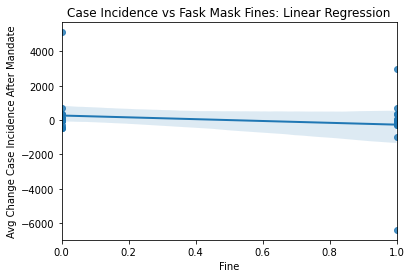

In [238]:
#work left to do: maybe make label for 0/1, set x axis ticks to only 0/1, find equation of lin regression line?
sns.scatterplot(x = "FMFINE",y = "avgChangeIncidence", data = policyDataClean, ax=ax)
sns.regplot(x = "FMFINE",y = "avgChangeIncidence", data = policyDataClean, line_kws={"lw":2})
plt.xlabel("Fine")
plt.ylabel("Avg Change Case Incidence After Mandate")
plt.title("Case Incidence vs Fask Mask Fines: Linear Regression")
plt.show()

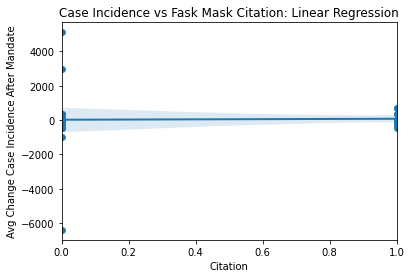

In [239]:
#ditto plot above
sns.scatterplot(x = "FMCITE",y = "avgChangeIncidence", data = policyDataClean)
sns.regplot(x = "FMCITE",y = "avgChangeIncidence", data = policyDataClean, line_kws={"lw":2})
plt.xlabel("Citation")
plt.ylabel("Avg Change Case Incidence After Mandate")
plt.title("Case Incidence vs Fask Mask Citation: Linear Regression")
plt.show()